In [3]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew


import numpy as np

from explain.pruned_trajectories import apply_pruning_mask, compute_gradcam_with_pca_projection


# enable autoreload     
%load_ext autoreload    
%autoreload 2

In [4]:
# Define your parameters here
positions_path = 'data/symbols/augmented_symbols.npy'
labels_path = 'data/symbols/augmented_labels.npy'

target_layer = 'encoder.0.layers.6'
device = 'cuda'  # or 'cpu' if you don't have a GPU
model_path = r'models\symbols.ckpt'

# Define the threshold for masking

gradcam_first_pc, positions_array, sample_labels = compute_gradcam_with_pca_projection(
    positions_path, labels_path, model_path, target_layer, device, 2
)


Positions shape: (1100, 2, 60)
Labels shape: (1100,)
Unique labels: ['(' ')' '\\Omega']
Sequence length (seq_len): 60
Computing Grad-CAM activations for all samples...


Grad-CAM Computation:  54%|█████▍    | 598/1100 [00:33<00:28, 17.84it/s]


KeyboardInterrupt: 

In [ ]:
threshold_value = 0.2  # Adjust this value as needed
pruned_positions_array, pruned_labels, pruned_part = apply_pruning_mask(
    gradcam_first_pc, positions_array, sample_labels, threshold_value
)

Percentage of data set to zero: 43.04%


In [ ]:
# Save the new pruned positions and labels
np.save('data/symbols/augmented_symbols_pruned.npy', pruned_positions_array)
np.save('data/symbols/augmented_labels_complete.npy', pruned_labels)
np.save('data/symbols/augmented_part_pruned.npy', pruned_part)

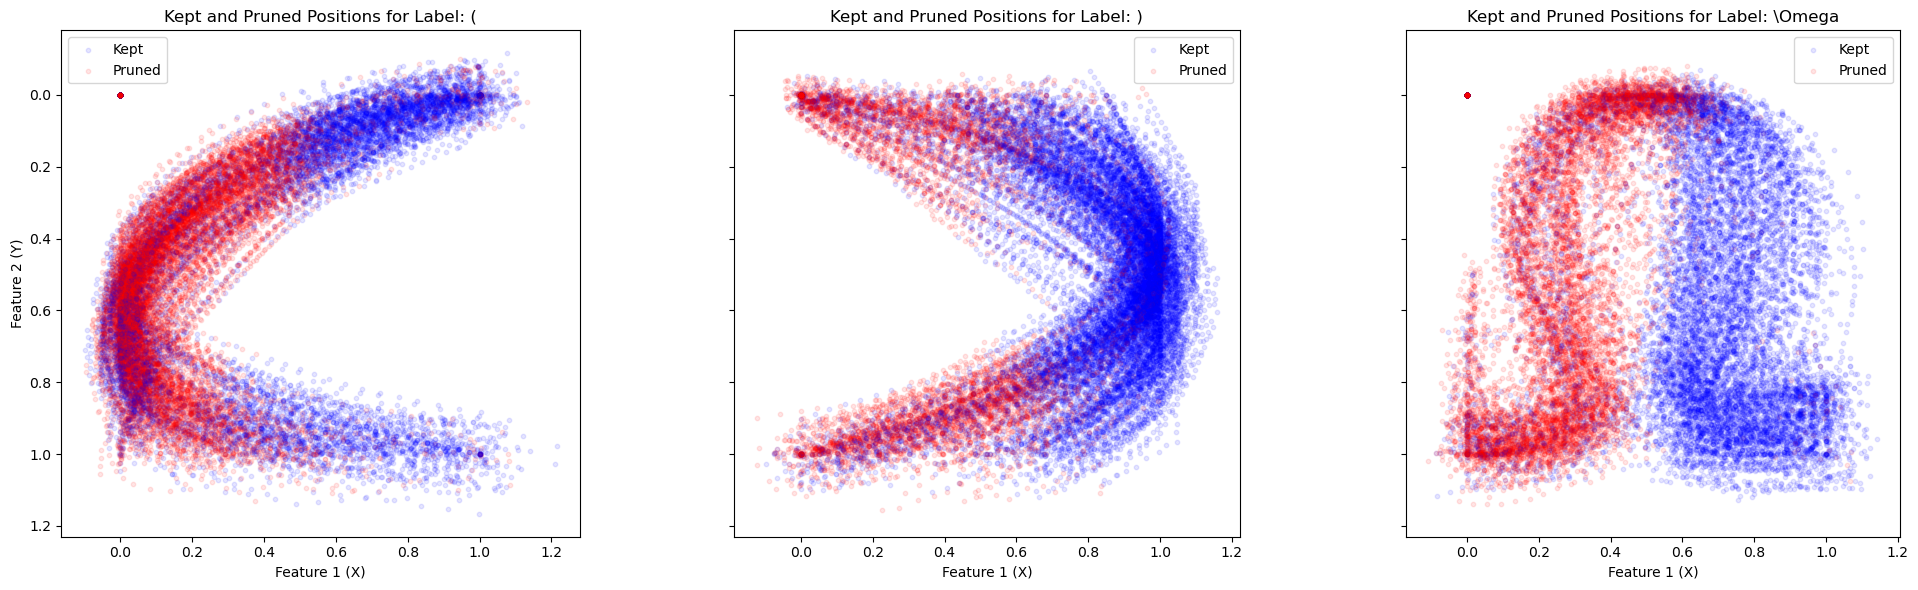

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pruned_positions_xy(pruned_positions_array, pruned_part, sample_labels, kept_alpha=0.1, pruned_alpha=0.1):
    """
    Plots the kept and pruned positions in an X-Y scatter plot for each unique label,
    with each plot displayed in a horizontally aligned subplot within the same figure.

    Args:
        pruned_positions_array (numpy.ndarray): Array of kept positions, shape (num_samples, seq_len, num_features).
        pruned_part (numpy.ndarray): Array of pruned positions, shape (num_samples, seq_len, num_features).
        sample_labels (numpy.ndarray): Array of labels per sample.
        kept_alpha (float): Alpha (transparency) value for the "Kept" points (blue).
        pruned_alpha (float): Alpha (transparency) value for the "Pruned" points (red).
    """
    unique_labels = np.unique(sample_labels)
    num_labels = len(unique_labels)
    
    # Create a single figure with horizontal subplots for each unique label
    fig, axes = plt.subplots(1, num_labels, figsize=(7 * num_labels, 6), sharey=True)
    
    for ax, label in zip(axes, unique_labels):
        label_indices = [i for i, lbl in enumerate(sample_labels) if lbl == label]
        
        # Scatter kept and pruned positions
        for idx in label_indices:
            kept_positions = pruned_positions_array[idx]
            pruned_positions = pruned_part[idx]
            
            # Assuming the first two features represent the X and Y coordinates
            kept_x = kept_positions[:, 0]
            kept_y = kept_positions[:, 1]
            pruned_x = pruned_positions[:, 0]
            pruned_y = pruned_positions[:, 1]
            
            # Plot kept points (blue)
            ax.scatter(kept_x, kept_y, color='blue', s=10, alpha=kept_alpha, label="Kept" if idx == label_indices[0] else "")
            
            # Plot pruned points (red)
            ax.scatter(pruned_x, pruned_y, color='red', s=10, alpha=pruned_alpha, label="Pruned" if idx == label_indices[0] else "")
        
        # Invert the y-axis for each subplot
        ax.invert_yaxis()
        ax.set_title(f"Kept and Pruned Positions for Label: {label}")
        ax.set_xlabel("Feature 1 (X)")
        if ax == axes[0]:  # Only set y-label for the first subplot
            ax.set_ylabel("Feature 2 (Y)")
        ax.legend()
        # Set aspect equal for each subplot
        ax.set_aspect('equal', 'box')

    # Adjust layout to remove whitespace between plots
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

# Example usage with adjustable alpha values
# plot_pruned_positions_xy(pruned_positions_array, pruned_part, sample_labels, kept_alpha=0.2, pruned_alpha=0.5)


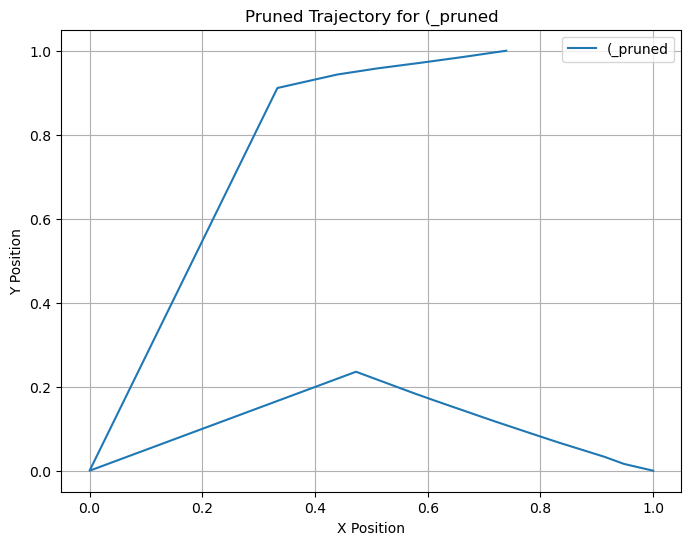

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot the first pruned trajectory
sample_index = 0  # Change this index to view different samples
pruned_positions = pruned_positions_array[sample_index]
label = pruned_labels[sample_index]

# Extract x and y positions (assuming positions_array has at least two features)
x_positions = pruned_positions[:, 0]
y_positions = pruned_positions[:, 1]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_positions, y_positions, linestyle='-', label=label)
plt.title(f'Pruned Trajectory for {label}')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()